In [55]:
path = r"C:\Users\schla\git\capo\results\agnews\mistral\CAPO\default_long\benchmark_experiment_agnews_mistral_CAPO_default_long\eac414135d4beaa2a3c24f16de77a4ba73ef222b9c99448e70552d4574f76b21\step_results.csv"
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

df = pd.read_csv(path)
df

,step,timestamp,time_elapsed,score,prompt,input_tokens_meta_llm,output_tokens_meta_llm,input_tokens_downstream_llm,output_tokens_downstream_llm
0,1,2025-03-14 01:39:00.723859,175.014169,0.854636,"Given this news article, what category does it...",1399,476,328131,54409
1,1,2025-03-14 01:39:00.723859,175.014169,0.827247,Determine the appropriate category for the fol...,1399,476,328131,54409
2,1,2025-03-14 01:39:00.723859,175.014169,0.814477,Examine the given news article and determine i...,1399,476,328131,54409
3,1,2025-03-14 01:39:00.723859,175.014169,0.782765,You are a news categorization system. Read the...,1399,476,328131,54409
4,1,2025-03-14 01:39:00.723859,175.014169,0.770165,Please read this news article carefully and as...,1399,476,328131,54409
...,...,...,...,...,...,...,...,...,...
755,76,2025-03-14 02:45:00.492590,19.601217,0.851081,You are tasked with categorizing news articles...,2306,1029,31297,3342
756,76,2025-03-14 02:45:00.492590,19.601217,0.851081,You are tasked with categorizing news articles...,2306,1029,31297,3342
757,76,2025-03-14 02:45:00.492590,19.601217,0.851081,You are tasked with categorizing news articles...,2306,1029,31297,3342
758,76,2025-03-14 02:45:00.492590,19.601217,0.847739,You are assigned to classify news articles int...,2306,1029,31297,3342


In [58]:
# group df by step and get the mean of the values (ignore stings)
df_grouped = df.groupby("step", as_index=False).mean(numeric_only=True)
# df_grouped["cum_input_tokens"] = df_grouped["input_tokens_downstream_llm"].cumsum()

# join the maximum score for each step
df_grouped = df_grouped.join(
    df.groupby("step", as_index=False).max()[["step", "score"]].set_index("step"),
    on="step",
    rsuffix="_max",
)

df_grouped

,step,time_elapsed,score,input_tokens_meta_llm,output_tokens_meta_llm,input_tokens_downstream_llm,output_tokens_downstream_llm,score_max
0,1,175.014169,0.768376,1399.0,476.0,328131.0,54409.0,0.854636
1,2,94.576515,0.783447,1540.0,653.0,231969.0,31064.0,0.846303
2,3,127.245312,0.785594,1429.0,528.0,341436.0,41355.0,0.839636
3,4,118.385403,0.802661,1751.0,843.0,360182.0,20635.0,0.839636
4,5,117.367998,0.809148,1893.0,861.0,341102.0,22371.0,0.839636
...,...,...,...,...,...,...,...,...
71,72,68.544348,0.848722,2336.0,1056.0,155996.0,12931.0,0.860478
72,73,33.119192,0.856727,2339.0,1062.0,71608.0,7712.0,0.875240
73,74,56.517186,0.840161,2308.0,1030.0,144554.0,12428.0,0.855663
74,75,21.733374,0.846776,2308.0,1030.0,49049.0,3666.0,0.860478


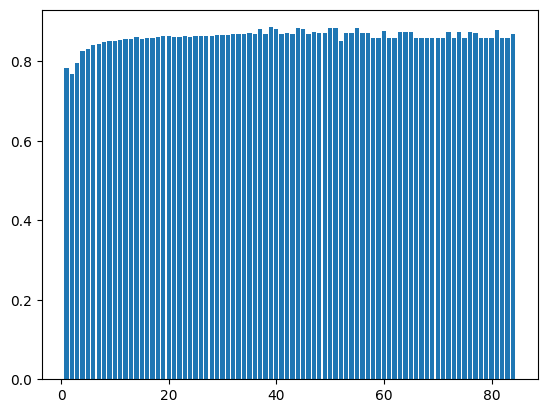

In [50]:
plt.bar(df_grouped["step"], df_grouped["score"]);

(0.8615130830489192, 0.9031797497155856)

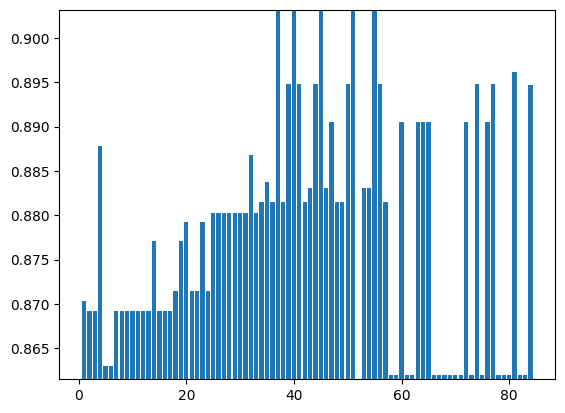

In [51]:
# plot token count vs step and adapt y-axis to min and max
column = "score_max"
plt.bar(df_grouped["step"], df_grouped[column])
plt.ylim(df_grouped[column].min(), df_grouped[column].max())

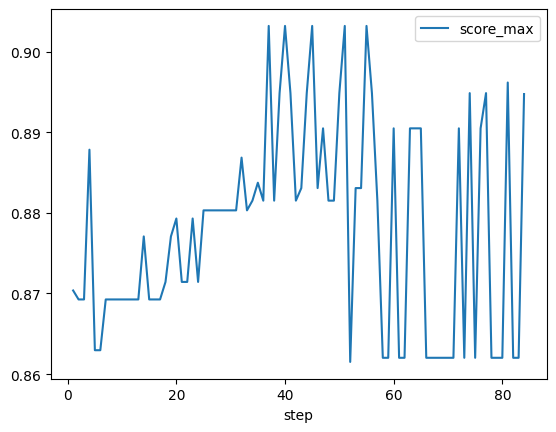

In [54]:
df_grouped.plot(x="step", y="score_max", kind="line");

### Analyze best prompts per step

In [59]:
df_best = df.groupby("step").apply(lambda x: x.nlargest(1, "score")).reset_index(drop=True)
prompts = df_best["prompt"].unique().tolist()
len(prompts)

C:\Users\schla\AppData\Local\Temp\ipykernel_6784\4144579215.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_best = df.groupby("step").apply(lambda x: x.nlargest(1, "score")).reset_index(drop=True)


9

In [60]:
df_best

,step,timestamp,time_elapsed,score,prompt,input_tokens_meta_llm,output_tokens_meta_llm,input_tokens_downstream_llm,output_tokens_downstream_llm
0,1,2025-03-14 01:39:00.723859,175.014169,0.854636,"Given this news article, what category does it...",1399,476,328131,54409
1,2,2025-03-14 01:40:35.302042,94.576515,0.846303,"Given this news article, what category does it...",1540,653,231969,31064
2,3,2025-03-14 01:42:42.548820,127.245312,0.839636,"Given this news article, what category does it...",1429,528,341436,41355
3,4,2025-03-14 01:44:40.935602,118.385403,0.839636,"Given this news article, what category does it...",1751,843,360182,20635
4,5,2025-03-14 01:46:38.304871,117.367998,0.839636,"Given this news article, what category does it...",1893,861,341102,22371
...,...,...,...,...,...,...,...,...,...
71,72,2025-03-14 02:42:49.516185,68.544348,0.860478,You are assigned to classify news articles int...,2336,1056,155996,12931
72,73,2025-03-14 02:43:22.636812,33.119192,0.875240,You are assigned to classify news articles int...,2339,1062,71608,7712
73,74,2025-03-14 02:44:19.155239,56.517186,0.855663,You are assigned to classify news articles int...,2308,1030,144554,12428
74,75,2025-03-14 02:44:40.890004,21.733374,0.860478,You are assigned to classify news articles int...,2308,1030,49049,3666


## Analyze Racing

In [ ]:
# load the prompt scores per block
path = r"C:\Users\schla\git\capo\results\results\sst-5\mistral\CAPO\seed44\benchmark_experiment_sst-5_mistral_CAPO_44\cbc743c08d16c22ec7791bac5008d8c2381cb9c1cee4856ddc2f2fef761ef521\prompt_scores_63.csv"

df_blocks = pd.read_csv(path)
# round all numbers to 2 decimal places
df_blocks = df_blocks.round(2)

df_blocks

,Unnamed: 0,0,1,2,3,4,5,6,7,8,9
0,Analyze the emotional tone and sentiment of th...,0.53,0.53,0.40,0.47,0.57,0.27,NaN,NaN,NaN,NaN
1,Analyze the emotional tone and sentiment of th...,0.63,0.67,0.33,0.57,0.63,0.47,0.50,0.53,0.63,0.5
2,Analyze the emotional tone and sentiment of th...,0.47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Analyze the emotional tone and sentiment of th...,0.53,0.60,0.47,0.50,0.53,0.43,0.47,0.53,0.40,NaN
4,Analyze the emotional tone and sentiment of th...,0.53,0.57,0.43,0.53,0.60,0.37,0.50,0.43,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
243,new prompt\n\nInput: and it marks him as one o...,0.57,0.57,0.53,0.50,0.47,0.40,0.27,0.47,0.43,NaN
244,new prompt\n\nInput: consider this review life...,0.57,0.57,0.33,0.50,0.47,0.40,0.33,0.40,0.37,NaN
245,new prompt\n\nInput: dreary tale of middle-cla...,0.43,0.53,0.43,0.53,0.40,0.37,0.23,NaN,NaN,NaN
246,"new prompt\n\nInput: it is depressing , ruthle...",0.40,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# load the prompt scores per block
path = r"C:\Users\schla\git\capo\results\local\benchmark_experiment_sst5_CAPO_44\cbc743c08d16c22ec7791bac5008d8c2381cb9c1cee4856ddc2f2fef761ef521\prompt_scores_1.csv"

df_blocks = pd.read_csv(path)
# round all numbers to 2 decimal places
df_blocks = df_blocks.round(2)

df_blocks

,Unnamed: 0,0,1,2,3,4,5
0,Analyze the emotional tone in each movie revie...,0.47,0.70,0.67,0.47,0.53,NaN
1,Analyze the provided movie review and identify...,0.47,0.73,0.73,0.57,0.70,0.53
2,Analyze the sentiment expressed in the given m...,0.40,NaN,NaN,NaN,NaN,NaN
3,Analyze the sentiment of each movie review in ...,0.40,0.70,0.63,0.43,NaN,NaN
4,Assess the tone of the provided film review an...,0.57,0.67,0.57,0.50,0.67,0.57
5,Determine the emotional tone of the following ...,0.43,0.63,NaN,NaN,NaN,NaN
6,Examine the following film critique and determ...,0.53,0.67,0.67,0.50,0.60,0.63
7,Movie Review Sentiment Categorization Task: As...,0.50,0.63,0.70,0.63,0.60,0.50
8,Movie review sentiment classification task: Fr...,0.40,0.67,0.57,NaN,NaN,NaN
9,Quick sentiment check - is this movie review v...,0.50,0.73,0.73,0.53,0.60,0.47


In [ ]:
# load the prompt scores per block
path = r"C:\Users\schla\git\capo\results\local\benchmark_experiment_sst5_CAPO_44\cbc743c08d16c22ec7791bac5008d8c2381cb9c1cee4856ddc2f2fef761ef521\prompt_scores_2.csv"

df_blocks = pd.read_csv(path)
# round all numbers to 2 decimal places
df_blocks = df_blocks.round(2)

df_blocks

,Unnamed: 0,0,1,2,3,4,5
0,Analyze the emotional tone in each movie revie...,0.47,0.70,0.67,0.47,0.53,NaN
1,Analyze the provided movie review and identify...,0.47,0.73,0.73,0.57,0.70,0.53
2,Analyze the sentiment expressed in the given m...,0.40,NaN,NaN,NaN,NaN,NaN
3,Analyze the sentiment of each movie review in ...,0.40,0.70,0.63,0.43,NaN,NaN
4,Assess the tone of the provided film review an...,0.57,0.67,0.57,0.50,0.67,0.57
5,Determine the emotional tone of the following ...,0.43,0.63,NaN,NaN,NaN,NaN
6,Examine the following film critique and determ...,0.53,0.67,0.67,0.50,0.60,0.63
7,Examine the given movie review to determine it...,0.47,0.70,0.67,0.60,0.53,0.53
8,Examine the given movie review to determine it...,0.60,0.70,0.70,0.43,NaN,NaN
9,Movie Review Sentiment Categorization Task: As...,0.50,0.63,0.70,0.63,0.60,0.50


In [ ]:
# best prompt
df[df["score"] == df["score"].max()].T

,0
step,1
timestamp,2025-03-13 22:26:22.354103
time_elapsed,112.864839
score,0.596647
prompt,Evaluate the emotional content of the followin...
input_tokens_meta_llm,1441
output_tokens_meta_llm,552
input_tokens_downstream_llm,107364
output_tokens_downstream_llm,33547
